## Contents
1. Initialize a pre-trained model from huggingface
1. Generate text from the model using huggingface pipeline
1. Inspect the model weights
1. Visualize the positional encodings
1. Sample from the model (without huggingface pipeline)

In [1]:
import matplotlib.pyplot as plt
from transformers import GPT2LMHeadModel

## Initializing the model

In [2]:
model_hf = GPT2LMHeadModel.from_pretrained("gpt2") # pretrained model with 124M parameters
print(f'Model object type: {type(model_hf)}\n')
print(model_hf)

Model object type: <class 'transformers.models.gpt2.modeling_gpt2.GPT2LMHeadModel'>

GPT2LMHeadModel(
  (transformer): GPT2Model(
    (wte): Embedding(50257, 768)
    (wpe): Embedding(1024, 768)
    (drop): Dropout(p=0.1, inplace=False)
    (h): ModuleList(
      (0-11): 12 x GPT2Block(
        (ln_1): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
        (attn): GPT2SdpaAttention(
          (c_attn): Conv1D()
          (c_proj): Conv1D()
          (attn_dropout): Dropout(p=0.1, inplace=False)
          (resid_dropout): Dropout(p=0.1, inplace=False)
        )
        (ln_2): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
        (mlp): GPT2MLP(
          (c_fc): Conv1D()
          (c_proj): Conv1D()
          (act): NewGELUActivation()
          (dropout): Dropout(p=0.1, inplace=False)
        )
      )
    )
    (ln_f): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
  )
  (lm_head): Linear(in_features=768, out_features=50257, bias=False)
)


## Generating from the model

In [3]:
from transformers import pipeline, set_seed
set_seed(42)
generator = pipeline('text-generation', model=model_hf, tokenizer='gpt2', device='cpu')
generator("Hello, I'm a language model,", max_length=30, num_return_sequences=5)

Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


[{'generated_text': "Hello, I'm a language model, but what I'm really doing is making a human-readable document. There are other languages, but those are"},
 {'generated_text': "Hello, I'm a language model, not a syntax model. That's why I like it. I've done a lot of programming projects.\n"},
 {'generated_text': "Hello, I'm a language model, and I'll do it in no time!\n\nOne of the things we learned from talking to my friend"},
 {'generated_text': "Hello, I'm a language model, not a command line tool.\n\nIf my code is simple enough:\n\nif (use (string"},
 {'generated_text': "Hello, I'm a language model, I've been using Language in all my work. Just a small example, let's see a simplified example."}]

## Inspecting the model weights

In [4]:
sd_hf = model_hf.state_dict() # the state of all the wights and biases of the model
for k, v in sd_hf.items():
    print(k, v.shape)

transformer.wte.weight torch.Size([50257, 768])
transformer.wpe.weight torch.Size([1024, 768])
transformer.h.0.ln_1.weight torch.Size([768])
transformer.h.0.ln_1.bias torch.Size([768])
transformer.h.0.attn.c_attn.weight torch.Size([768, 2304])
transformer.h.0.attn.c_attn.bias torch.Size([2304])
transformer.h.0.attn.c_proj.weight torch.Size([768, 768])
transformer.h.0.attn.c_proj.bias torch.Size([768])
transformer.h.0.ln_2.weight torch.Size([768])
transformer.h.0.ln_2.bias torch.Size([768])
transformer.h.0.mlp.c_fc.weight torch.Size([768, 3072])
transformer.h.0.mlp.c_fc.bias torch.Size([3072])
transformer.h.0.mlp.c_proj.weight torch.Size([3072, 768])
transformer.h.0.mlp.c_proj.bias torch.Size([768])
transformer.h.1.ln_1.weight torch.Size([768])
transformer.h.1.ln_1.bias torch.Size([768])
transformer.h.1.attn.c_attn.weight torch.Size([768, 2304])
transformer.h.1.attn.c_attn.bias torch.Size([2304])
transformer.h.1.attn.c_proj.weight torch.Size([768, 768])
transformer.h.1.attn.c_proj.bias 

1. We can see that the first item in this dictionary is the embedding weight matrix, with a vocabulary size of `50257` and an output dimension size of `768`. 
2. The second item is the positional encoding matrix, which encodes each of the `1024` positions in the context length by a vector of length `768`.

## Visualizing the positional encodings (for fun)

torch.Size([1024, 768])


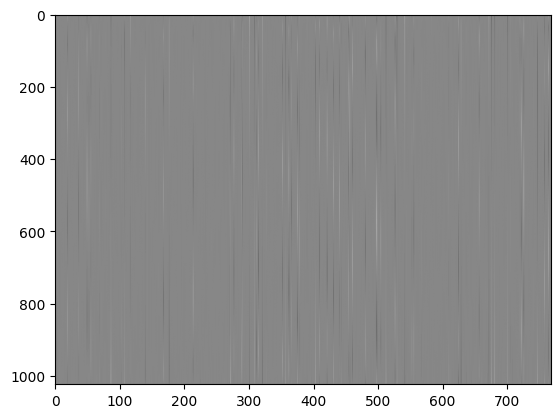

In [5]:
# visualizing the position encodings
positional_encodings = sd_hf['transformer.wpe.weight']
print(positional_encodings.size()) # 1024 positions, 768 dimensions
plt.imshow(positional_encodings, aspect='auto', cmap='gray');

This is the structure of the positional encodings that are learned by the model for each position in the `1024` size context window.

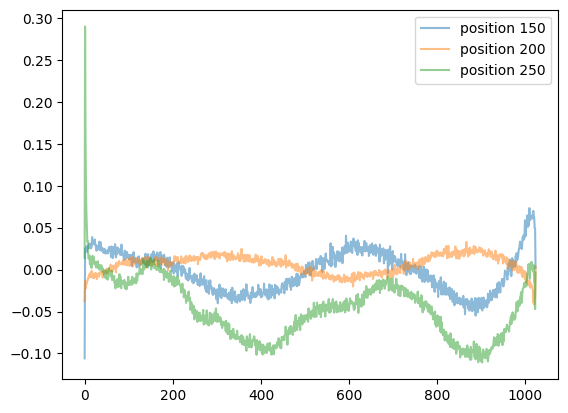

In [6]:
plt.plot(positional_encodings[:, 128], label='position 150', alpha=0.5);
plt.plot(positional_encodings[:, 256], label='position 200', alpha=0.5);
plt.plot(positional_encodings[:, 512], label='position 250', alpha=0.5);
plt.legend();

In the original "Attention is all you need" paper, these positional encodings are fixed at the start of training to sums of sine waves at different frequencies, however in the GPT-2 paper, they are learned during training which seems to work just as well.

## Sampling without `pipeline` for matching results

In [7]:
import torch
from torch.nn import functional as F
import tiktoken

In [8]:
num_return_sequences = 5
max_length = 30

In [9]:
model_hf.eval(); # good practice even if you do not use dropout or batchnorm
model_hf.to('cuda');

In [10]:
enc = tiktoken.get_encoding('gpt2')
tokens = enc.encode("Hello, I'm a language model,")
tokens = torch.tensor(tokens, dtype=torch.long) # (8, )
tokens = tokens.unsqueeze(0).repeat(num_return_sequences, 1) # (5, 8)
print(tokens) # this will be the first input to the auto-regressive model

tensor([[15496,    11,   314,  1101,   257,  3303,  2746,    11],
        [15496,    11,   314,  1101,   257,  3303,  2746,    11],
        [15496,    11,   314,  1101,   257,  3303,  2746,    11],
        [15496,    11,   314,  1101,   257,  3303,  2746,    11],
        [15496,    11,   314,  1101,   257,  3303,  2746,    11]])


In [11]:
torch.manual_seed(42)
torch.cuda.manual_seed(42)
x = tokens.to('cuda') # (B, T) = (5, 8)
while x.size(1) < max_length:
    with torch.no_grad():
        model_output = model_hf(x) # (B, T, vocab_size)
        logits = model_output.logits
        logits = logits[:, -1, :] # (B, vocab_size)
        probs = F.softmax(logits, dim=-1) # (B, vocab_size)
        topk_probs, topk_indices = torch.topk(probs, 50, dim=-1) # (B, 50)
        ix = torch.multinomial(topk_probs, 1) # (B, 1)
        xcol = torch.gather(topk_indices, 1, ix) # (B, 1)
        x = torch.cat((x, xcol), dim=1)

In [12]:
for i in range(num_return_sequences):
    tokens = x[i, :max_length].tolist()
    print(enc.decode(tokens))

Hello, I'm a language model, not a program.

So this morning I started studying for the interview in the lab. This was not
Hello, I'm a language model, and one of the main things that bothers me when they create languages is how easy it becomes to create something that
Hello, I'm a language model, and I wrote it off on the grounds that a language model would make me more fluent. But I'm not
Hello, I'm a language model, I really like languages. I like languages because like, they're good. And the way we talk about languages
Hello, I'm a language model, a language model I'm using for data modelling. All I did was test the results and then I wrote some
